#TextRank 
TextRank (2004) is a graph-based ranking model for text processing, based on Google’s PageRank algorithm, that finds the most relevant sentences in a text. PageRank was the first algorithm used by Google search engine to sort web pages in 1998. In a nutshell, if page A links to page B and page C, page B links to page C, the sorting would be page C, page B, page A.

TextRank is very easy to use because it’s unsupervised. First, the whole text is split into sentences, then the algorithm builds a graph where sentences are the nodes and overlapped words are the links. Finally, PageRank identifies the most important nodes of this network of sentences.

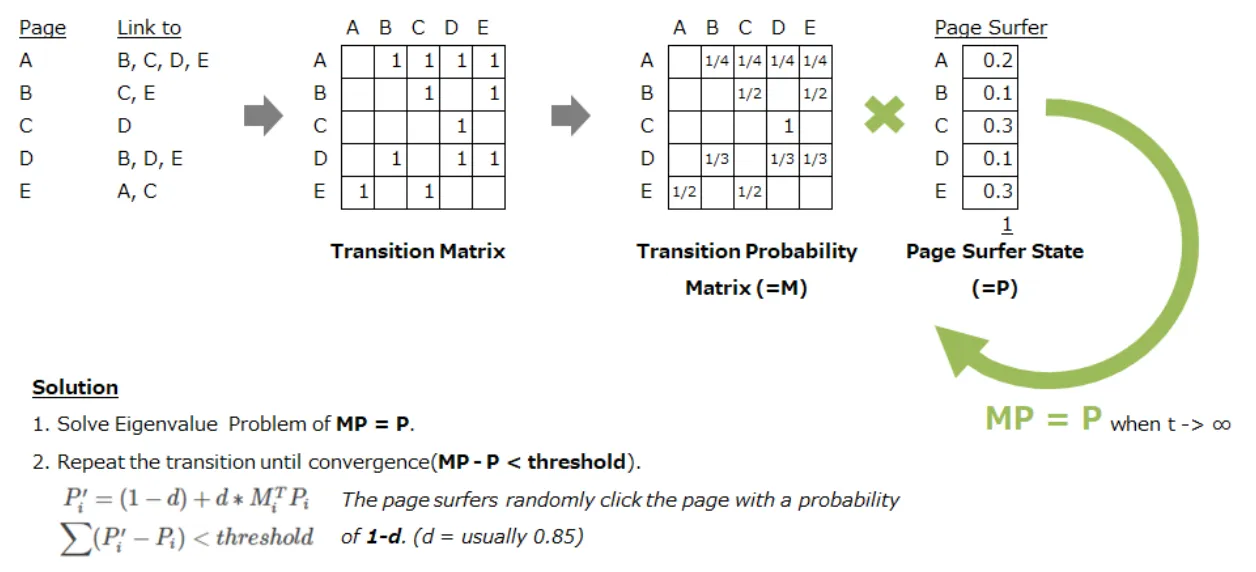

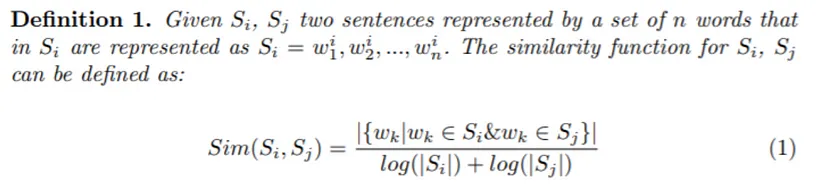

However, the updated algorithm uses Okapi BM25 function to see how similar the sentences are. BM25 / Okapi-BM25 is a ranking function widely used as the state of the art for Information Retrieval tasks. BM25 is a variation of the TF-IDF model using a probabilistic model.
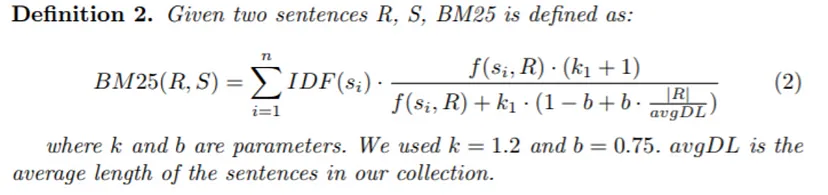

In a nutshell, this function penalizes words that appears in more than half the documents of the collection by giving them a negative value.

# TextRank

## Import

In [ ]:
! pip install contractions datasets rouge tqdm gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.3 MB/s eta 0:00:00


In [ ]:
#!pip install gensim==3.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 45.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.2-cp310-cp310-linux_x86_64.whl size=24951116 sha256=660531cae74950d88af68aa1392eb8c7c76dce78770f051c3331adb74d149a29
  Stored in directory: /root/.cache/pip/wheels/42/03/36/82090cfd4d91edcffcddb72ce379c0db1b8c3e257342dc223c
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [ ]:
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import contractions
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import rouge

import gensim
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

'''
import tensorflow as tf
from tensorflow.keras import callbacks, models, layers, preprocessing as kp
from keras.models import load_model
'''

from scipy import spatial
import networkx as nx

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from contractions import contractions_dict
contractions_dict.update({"she'll've" : "she will have"})
contractions_dict.update({"I'd" : "I had"})

wordnet_lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = SnowballStemmer("english")

l_stopwrds = nltk.corpus.stopwords.words("english")
l_stopwrds = l_stopwrds + ["cnn","CNN","u"]
l_stopwrds = l_stopwrds + ["say","said","new"] #frequent words

In [ ]:
ds = datasets.load_dataset("cnn_dailymail",'3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Data Processing

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
lst_dics = [dic for dic in ds["train"]]
df = pd.DataFrame(lst_dics)
df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [ ]:
df = df.rename(columns = {"article":"text", "highlights":"y"})
df = df[["text","y"]]
df

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."
...,...,...
287108,"The nine-year-old daughter of a black, unarmed...","Rumain Brisbon, 34, was killed after Phoenix p..."
287109,Legalising assisted suicide is a slippery slop...,"Theo Boer, a European assisted suicide watchdo..."
287110,A group calling itself 'The Women of the 99 Pe...,Ohio congressman criticised for 'condoning the...
287111,Most men enjoy a good pint of lager or real al...,The Black Country Ale Tairsters have been to 1...


In [ ]:
#lets us train and test using a portion of dataset
#let us assume there are some summary that are longer than the text let us ignore them
c = []
for i in range(len(df)):
    if len(df['text'].iloc[i]) < len(df['y'].iloc[i]):
        c.append(i)
c

[1511,
 1706,
 2902,
 6353,
 71791,
 111937,
 119897,
 161208,
 171936,
 183358,
 183957,
 189331,
 206572,
 224925,
 225460,
 227432,
 228230,
 244504,
 251571,
 279947,
 282030,
 285924]

In [ ]:
df = df.drop(index=c)

In [ ]:
df.shape

(287091, 2)

In [ ]:
#we take 40000 rows from the dataset into consideration
df = df.iloc[:40000]
#the +1 is for refernce
df.reset_index(inplace = True)
df = df.drop(["index"],axis=1)
df

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."
...,...,...
39995,(CNN) -- Major pharmaceutical companies are in...,Africa's urban middle class is attracting phar...
39996,Hong Kong (CNN) -- Tsang Tsz-Kwan may look lik...,Blind Hong Kong student learned to read Braill...
39997,"Washington (CNN) -- O.J. Simpson, Casey Anthon...","In recent high profile cases -- Zimmerman, Ant..."
39998,"New Delhi (CNN) -- At least 28 people, many of...",NEW: The train driver is seriously injured aft...


In [ ]:
x = df.iloc[0]
x

text    LONDON, England (Reuters) -- Harry Potter star...
y       Harry Potter star Daniel Radcliffe gets £20M f...
Name: 0, dtype: object

In [ ]:
#text
print(x['text'])
print("------Summary------")
#Summary
print(x['y'])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

## Cleaning and Processing Text

In [ ]:
#expand contractions
from contractions import contractions_dict
contractions_dict.update({"she'll've" : "she will have"})
contractions_dict.update({"I'd" : "I had"})

def _get_contractions(contractions_dict):
    contractions_keys = '|'.join(contractions_dict.keys())
    contraction_re = re.compile(f'({contractions_keys})', flags=re.DOTALL)
    return contractions_dict, contraction_re

contractions, contractions_re = _get_contractions(contractions_dict)

def replace_contractions(text):
    def replace(x):
        match = x.group(0)
        expanded_contraction = contractions_dict.get(match)
        if not expanded_contraction:
            return match
        return expanded_contraction
    
    txt = contractions_re.sub(replace, text)
    txt = re.sub("'", "", txt)
    return txt

contractions_re

re.compile(r"(I'm|I'm'a|I'm'o|I've|I'll|I'll've|I'd|I'd've|Whatcha|amn't|ain't|aren't|'cause|can't|can't've|could've|couldn't|couldn't've|daren't|daresn't|dasn't|didn't|didn’t|don't|don’t|doesn't|e'er|everyone's|finna|gimme|gon't|gonna|gotta|hadn't|hadn't've|hasn't|haven't|he've|he's|he'll|he'll've|he'd|he'd've|here's|how're|how'd|how'd'y|how's|how'll|isn't|it's|'tis|'twas|it'll|it'll've|it'd|it'd've|kinda|let's|luv|ma'am|may've|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|ne'er|o'|o'clock|ol'|oughtn't|oughtn't've|o'er|shan't|sha'n't|shalln't|shan't've|she's|she'll|she'd|she'd've|should've|shouldn't|shouldn't've|so've|so's|somebody's|someone's|something's|sux|that're|that's|that'll|that'd|that'd've|'em|there're|there's|there'll|there'd|there'd've|these're|they're|they've|they'll|they'll've|they'd|they'd've|this's|this'll|this'd|those're|to've|wanna|wasn't|we're|we've|we'll|we'll've|we'd|we'd've|weren't|what're|what'd|what've|what's|what'll|what'll'

In [ ]:
#clean punctuations
puncts=[",", ".", "“", ":", ")", "(", "-", "!", "?", "|", ";", "$", "&", "/", "[", "]", ">", "%", "=", "#", "*", "+", "\\", 
 "•", "~", "@", "£", "·", "_", "{", "}", "©", "^", "®", "`", "<", "→", "°", "€", "™", "›", "♥", "←", "×", "§", "″", "′", 
 "█", "…", "“", "★", "”", "–", "●", "►", "−", "¢", "¬", "░", "¡", "¶", "↑", "±", "¿", "▾", "═", "¦", "║", "―", "¥", "▓", 
 " — ", "‹", "─", "▒", "：", "⊕", "▼", "▪", "†", "■", "▀", "¨", "▄", "♫", "☆", "¯", "♦", "¤", "▲", "¸", "⋅", "∞", 
 "∙", "）", "↓", "、", "│", "（", "»", "，", "♪", "╩", "╚", "・", "╦", "╣", "╔", "╗", "▬", "❤", "≤", "‡", "√", "◄", "━", 
 "⇒", "▶", "≥", "╝", "♡", "◊", "。", "✈", "≡", "☺", "✔", "≈", "✓", "♣", "☎", "℃", "◦", "└", "‟", "～", "！", "○", 
 "◆", "№", "♠", "▌", "✿", "▸", "⁄", "□", "❖", "✦", "．", "÷", "｜", "┃", "／", "￥", "╠", "↩", "✭", "▐", "☼", "☻", "┐", 
 "├", "«", "∼", "┌", "℉", "☮", "฿", "≦", "♬", "✧", "〉", "－", "⌂", "✖", "･", "◕", "※", "‖", "◀", "‰", "\x97", "↺", 
 "∆", "┘", "┬", "╬", "،", "⌘", "⊂", "＞", "〈", "⎙", "？", "☠", "⇐", "▫", "∗", "∈", "≠", "♀", "♔", "˚", "℗", "┗", "＊", 
 "┼", "❀", "＆", "∩", "♂", "‿", "∑", "‣", "➜", "┛", "⇓", "☯", "⊖", "☀", "┳", "；", "∇", "⇑", "✰", "◇", "♯", "☞", "´", 
 "↔", "┏", "｡", "◘", "∂", "✌", "♭", "┣", "┴", "┓", "✨", "\xa0", "˜", "❥", "┫", "℠", "✒", "［", "∫", "\x93", "≧", "］", 
 "\x94", "∀", "♛", "\x96", "∨", "◎", "↻", "⇩", "＜", "≫", "✩", "✪", "♕", "؟", "₤", "☛", "╮", "␊", "＋", "┈", "％", 
 "╋", "▽", "⇨", "┻", "⊗", "￡", "।", "▂", "✯", "▇", "＿", "➤", "✞", "＝", "▷", "△", "◙", "▅", "✝", "∧", "␉", "☭", 
 "┊", "╯", "☾", "➔", "∴", "\x92", "▃", "↳", "＾", "׳", "➢", "╭", "➡", "＠", "⊙", "☢", "˝", "∏", "„", "∥", "❝", "☐", 
 "▆", "╱", "⋙", "๏", "☁", "⇔", "▔", "\x91", "➚", "◡", "╰", "\x85", "♢", "˙", "۞", "✘", "✮", "☑", "⋆", "ⓘ", "❒", 
 "☣", "✉", "⌊", "➠", "∣", "❑", "◢", "ⓒ", "\x80", "〒", "∕", "▮", "⦿", "✫", "✚", "⋯", "♩", "☂", "❞", "‗", "܂", "☜", 
 "‾", "✜", "╲", "∘", "⟩", "＼", "⟨", "·", "✗", "♚", "∅", "ⓔ", "◣", "‘͡", "‛", "❦", "◠", "✄", "❄", "∃", "␣", "≪", "｢", 
 "≅", "◯", "☽", "∎", "｣", "❧", "ⓐ", "↘", "⚓", "▣", "˘", "∪", "⇢", "✍", "⊥", "＃", "⎯", "↠", "۩", "☰", "◥", 
 "⊆", "✽", "⚡", "↪", "❁", "☹", "◼", "☃", "◤", "❏", "ⓢ", "⊱", "➝", "‘̣", "✡", "∠", "｀", "▴", "┤", "∝", "♏", "ⓐ", 
 "✎", ";", "␤", "＇", "❣", "✂", "✤", "ⓞ", "☪", "✴", "⌒", "˛", "♒", "＄", "✶", "▻", "ⓔ", "◌", "◈", "❚", "❂", "￦", 
 "◉", "╜", "‘̃", "✱", "╖", "❉", "ⓡ", "↗", "ⓣ", "♻", "➽", "׀", "✲", "✬", "☉", "▉", "≒", "☥", "⌐", "♨", "✕", "ⓝ", 
 "⊰", "❘", "＂", "⇧", "‘̵", "➪", "▁", "▏", "⊃", "ⓛ", "‚", "♰", "‘́", "✏", "⏑", "‘̶", "ⓢ", "⩾", "￠", "❍", "≃", "⋰", "♋", 
 "､", "‘̂", "❋", "✳", "ⓤ", "╤", "▕", "⌣", "✸", "℮", "⁺", "▨", "╨", "ⓥ", "♈", "❃", "☝", "✻", "⊇", "≻", "♘", "♞", 
 "◂", "✟", "⌠", "✠", "☚", "✥", "❊", "ⓒ", "⌈", "❅", "ⓡ", "♧", "ⓞ", "▭", "❱", "ⓣ", "∟", "☕", "♺", "∵", "⍝", "ⓑ", 
 "✵", "✣", "٭", "♆", "ⓘ", "∶", "⚜", "◞", "்", "✹", "➥", "↕", "‘̳", "∷", "✋", "➧", "∋", "‘̿", "ͧ", "┅", "⥤", "⬆", "⋱", 
 "☄", "↖", "⋮", "۔", "♌", "ⓛ", "╕", "♓", "❯", "♍", "▋", "✺", "⭐", "✾", "♊", "➣", "▿", "ⓑ", "♉", "⏠", "◾", "▹", 
 "⩽", "↦", "╥", "⍵", "⌋", "։", "➨", "∮", "⇥", "ⓗ", "ⓓ", "⁻", "⎝", "⌥", "⌉", "◔", "◑", "✼", "♎", "♐", "╪", "⊚", 
 "☒", "⇤", "ⓜ", "⎠", "◐", "⚠", "╞", "◗", "⎕", "ⓨ", "☟", "ⓟ", "♟", "❈", "↬", "ⓓ", "◻", "♮", "❙", "♤", "∉", "؛", 
 "⁂", "ⓝ", "־", "♑", "╫", "╓", "╳", "⬅", "☔", "☸", "┄", "╧", "׃", "⎢", "❆", "⋄", "⚫", "‘̏", "☏", "➞", "‘͂", "␙", 
 "ⓤ", "◟", "‘̊", "⚐", "✙", "↙", "‘̾", "℘", "✷", "⍺", "❌", "⊢", "▵", "✅", "ⓖ", "☨", "▰", "╡", "ⓜ", "☤", "∽", "╘", 
 "‘˹", "↨", "♙", "⬇", "♱", "⌡", "⠀", "╛", "❕", "┉", "ⓟ", "‘̀", "♖", "ⓚ", "┆", "⎜", "◜", "⚾", "⤴", "✇", "╟", "⎛", 
 "☩", "➲", "➟", "ⓥ", "ⓗ", "⏝", "◃", "╢", "↯", "✆", "‘˃", "⍴", "❇", "⚽", "╒", "‘̸", "♜", "☓", "➳", "⇄", "☬", "⚑", 
 "✐", "⌃", "◅", "▢", "❐", "∊", "☈", "॥", "⎮", "▩", "ு", "⊹", "‵", "␔", "☊", "➸", "‘̌", "☿", "⇉", "⊳", "╙", "ⓦ", 
 "⇣", "｛", "‘̄", "↝", "⎟", "▍", "❗", "״", "΄", "▞", "◁", "⛄", "⇝", "⎪", "♁", "⇠", "☇", "✊", "ி", "｝", "⭕", "➘", 
 "⁀", "☙", "❛", "❓", "⟲", "⇀", "≲", "ⓕ", "⎥", "\u06dd", "ͤ", "₋", "‘̱", "‘̎", "♝", "≳", "▙", "➭", "܀", "ⓖ", "⇛", "▊", 
 "⇗", "‘̷", "⇱", "℅", "ⓧ", "⚛", "‘̐", "‘̕", "⇌", "␀", "≌", "ⓦ", "⊤", "‘̓", "☦", "ⓕ", "▜", "➙", "ⓨ", "⌨", "◮", "☷", 
 "◍", "ⓚ", "≔", "⏩", "⍳", "℞", "┋", "‘˻", "▚", "≺", "‘ْ", "▟", "➻", "‘̪", "⏪", "‘̉", "⎞", "┇", "⍟", "⇪", "▎", "⇦", "␝", 
 "⤷", "≖", "⟶", "♗", "‘̴", "♄", "ͨ", "‘̈", "❜", "‘̡", "▛", "✁", "➩", "ா", "‘˂", "↥", "⏎", "⎷", "‘̲", "➖", "↲", "⩵", "‘̗", "❢", 
 "≎", "⚔", "⇇", "‘̑", "⊿", "‘̖", "☍", "➹", "⥊", "⁁", "✢"]

def clean_punct(text):
    for punct in puncts:
        if punct in text:
            text = text.replace(punct, "")
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
#stopwords
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

l_stopwrds = nltk.corpus.stopwords.words("english")
l_stopwrds = l_stopwrds + ["cnn","CNN","u"]
l_stopwrds = l_stopwrds + ["say","said","new"] #frequent words

def remove_stopwords(text,lst_stopwrds = l_stopwrds):
    tokens = [token.strip() for token in text]
    tokens = [token for token in tokens if token not in l_stopwrds]
    return tokens

In [ ]:
#stemming
from nltk.stem import SnowballStemmer

def stem_text(text):
    stemmer = SnowballStemmer("english")
    tokens = [token.strip() for token in text]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [ ]:
#lematization
from nltk.stem import WordNetLemmatizer

def lemma_text(text):
    wordnet_lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    tokens = [token.strip() for token in text]
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [ ]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

def preprocess_txt(txt,stopword_lst,st=False):
    #separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))

    #expand contradiction
    txt = replace_contractions(txt)

    #clean punctuations
    txt = clean_punct(txt)

    txt = " ".join([word.strip() for word in txt.split()])

    txt = txt.lower()

    ### tokenize (convert from string to list)
    lst_txt = txt.split()

    #stopwords removal
    lst_txt = remove_stopwords(lst_txt ,stopword_lst)
    
    #lemmatization
    lst_txt = lemma_text(lst_txt)

    #stemming
    if st is True:
        lst_txt = stem_text(lst_txt)

    #stopwords removal
    lst_txt = remove_stopwords(lst_txt ,stopword_lst)

    txt = " ".join(lst_txt)

    return txt

In [ ]:
#Save 20000 for later test and 20000 for train
df_train = df.iloc[10000:30000]
df_test = df.iloc[:10000]

## Continue

In [ ]:
#from saved
df_train = pd.read_csv('/content/drive/MyDrive/miniproject/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/miniproject/df_test.csv')

In [ ]:
testd = pd.read_csv("/content/drive/MyDrive/miniproject/testd.csv",index_col="Unnamed: 0")
teste = pd.read_csv("/content/drive/MyDrive/miniproject/teste.csv",index_col="Unnamed: 0")

In [ ]:
from tqdm import tqdm
tqdm.pandas()
teste.loc[:, "text_clean"] = teste["text"].progress_apply(lambda x: preprocess_txt(x, stopword_lst=l_stopwrds, st=False))
teste.loc[:, "y_clean"] = teste["y"].progress_apply(lambda x: preprocess_txt(x, stopword_lst=l_stopwrds, st=False))

100%|██████████| 11/11 [00:00<00:00, 1188.59it/s]


## TR

In [ ]:
#checking if data is flat
def is_nested(x):
    return isinstance(x, (list, np.ndarray))

# count the number of nested elements in column B
num_nested = testd['text_clean'].apply(is_nested).sum()
print(num_nested)

num_nested = teste['text'].apply(is_nested).sum()
print(num_nested)

0
0


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove6bwb = "/content/drive/MyDrive/miniproject/glove.6B.200d.txt"

In [ ]:
txt = testd['text'].iloc[0]
per = 0.3

sentences = sent_tokenize(txt)
sz = int(np.ceil(len(sentences) * per))
print(sz)
sentences

5


["LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him.",
 'Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.',
 '"I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.',
 '"I don\'t think I\'ll be particularly extravagant.',
 '"The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."',
 'At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box off

In [ ]:
clean_sent = []
for i in range(len(sentences)):
    clean_sent.append(preprocess_txt(sentences[i], l_stopwrds))

In [ ]:
# Extract word vectors
word_embeddings = {}
f = open(glove6bwb, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [ ]:
word_embeddings['the'].shape

(200,)

In [ ]:
sentence_vectors = []
for i in clean_sent:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((200,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((200,))
    sentence_vectors.append(v)

In [ ]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])
sim_mat.shape

(24, 24)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,200), sentence_vectors[j].reshape(1,200))[0,0]

print(sim_mat.shape)
sim_mat[:5,:5]  

(24, 24)


array([[0.        , 0.84618926, 0.84776133, 0.5218752 , 0.73685706],
       [0.84618926, 0.        , 0.82099652, 0.61584979, 0.74229658],
       [0.84776133, 0.82099652, 0.        , 0.68599373, 0.80968076],
       [0.5218752 , 0.61584979, 0.68599373, 0.        , 0.66494864],
       [0.73685706, 0.74229658, 0.80968076, 0.66494864, 0.        ]])

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [ ]:
ranked_sentences

[(0.04765860981098019,
  '"I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.'),
 (0.047232846937351074,
  '"People are always looking to say \'kid star goes off the rails,\'" he told reporters last month.'),
 (0.04634730851984592,
  'At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart.'),
 (0.04633596888628161,
  "Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch."),
 (0.0461637781656987,
  'Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parti

In [ ]:
# Generate summary
for i in range(sz):
    print(ranked_sentences[i][1])

"I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.
"People are always looking to say 'kid star goes off the rails,'" he told reporters last month.
At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart.
Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.


# Func

In [ ]:
def word_to_vec_glove(glove_file):
    with open(glove_file, encoding='utf8') as f:
        word_to_vec = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

In [ ]:
def get_sentence_vectors(sentences, word_embeddings, size):
    sentence_vectors = []
    for i in sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((size,))) for w in i.split()]) / (len(i.split()) + 0.001)
        else:
            v = np.zeros((size,))
        sentence_vectors.append(v)
    return sentence_vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_similarity_matrix(sentence_vectors,size):
    sim_mat = np.zeros([len(sentence_vectors), len(sentence_vectors)])
    for i in range(len(sentence_vectors)):
        for j in range(len(sentence_vectors)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,size), 
                                                   sentence_vectors[j].reshape(1,size))[0,0]
    return sim_mat

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
glove6bwb = "/content/drive/MyDrive/miniproject/glove.6B.200d.txt"

word_embeddings = word_to_vec_glove(glove6bwb)

def trsummary(txt,word_embeddings,per = 0.2):
    sentences = sent_tokenize(txt)
    sz = int(np.ceil(len(sentences) * per))
    if(sz<3 and len(sentences)>3):
        p = int(np.ceil(len(sentences) * 0.8))#for small text

    clean_sent = []
    for i in range(len(sentences)):
        clean_sent.append(preprocess_txt(sentences[i], l_stopwrds))

    size = word_embeddings['the'].shape[0]
    sentence_vectors = get_sentence_vectors(sentences,word_embeddings,size)

    sim_mat = get_similarity_matrix(sentence_vectors,size)

    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph)

    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

    summary = []
    for i in range(sz):
        summary.append(ranked_sentences[i][1])
    f_summary = [sent for sent in summary]
    summary = ' '.join(f_summary)
    return summary

In [ ]:
print(trsummary(txt,word_embeddings,0.3))

"I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Meanwhile, he is braced for even

## test

In [ ]:
from tqdm import tqdm
tqdm.pandas()
testd['trpred'] = testd['text'].progress_apply(lambda x : trsummary(x,word_embeddings,0.3))

100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


In [ ]:
tqdm.pandas()
teste['trpred'] = teste['text'].progress_apply(lambda x : trsummary(x,word_embeddings,0.3))

100%|██████████| 11/11 [00:00<00:00, 49.94it/s]


## ROUGE 
Recall-Oriented Understudy for Gisting Evaluation


In [ ]:
import rouge
def evaluate_summary(y_test, predicted):    
   rouge_score = rouge.Rouge()    
   scores = rouge_score.get_scores(y_test, predicted, avg=True)       
   score_1 = round(scores['rouge-1']['f'], 2)    
   score_2 = round(scores['rouge-2']['f'], 2)    
   score_L = round(scores['rouge-l']['f'], 2)    
   print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_L, "--> avg rouge:", round(np.mean([score_1,score_2,score_L]), 2))
   return np.mean([score_1,score_2,score_L])

In [ ]:
lstr = []
for i in testd.index:
    x = evaluate_summary(testd['ey'][i], testd['trpred'][i])
    lstr.append(x)
print("teste")
for i in teste.index:
    x = evaluate_summary(teste['ey'][i], teste['trpred'][i])
    lstr.append(x)

rouge1: 0.87 | rouge2: 0.82 | rougeL: 0.87 --> avg rouge: 0.85
rouge1: 0.86 | rouge2: 0.81 | rougeL: 0.86 --> avg rouge: 0.84
rouge1: 0.84 | rouge2: 0.78 | rougeL: 0.83 --> avg rouge: 0.82
rouge1: 0.66 | rouge2: 0.55 | rougeL: 0.66 --> avg rouge: 0.62
rouge1: 0.73 | rouge2: 0.66 | rougeL: 0.73 --> avg rouge: 0.71
rouge1: 0.8 | rouge2: 0.74 | rougeL: 0.8 --> avg rouge: 0.78
rouge1: 0.76 | rouge2: 0.69 | rougeL: 0.75 --> avg rouge: 0.73
rouge1: 0.69 | rouge2: 0.6 | rougeL: 0.68 --> avg rouge: 0.66
rouge1: 1.0 | rouge2: 1.0 | rougeL: 1.0 --> avg rouge: 1.0
rouge1: 0.87 | rouge2: 0.82 | rougeL: 0.87 --> avg rouge: 0.85
rouge1: 0.91 | rouge2: 0.86 | rougeL: 0.91 --> avg rouge: 0.89
rouge1: 0.77 | rouge2: 0.74 | rougeL: 0.77 --> avg rouge: 0.76
rouge1: 0.8 | rouge2: 0.73 | rougeL: 0.78 --> avg rouge: 0.77
rouge1: 0.76 | rouge2: 0.72 | rougeL: 0.76 --> avg rouge: 0.75
rouge1: 0.74 | rouge2: 0.69 | rougeL: 0.74 --> avg rouge: 0.72
rouge1: 0.45 | rouge2: 0.32 | rougeL: 0.42 --> avg rouge: 0.4
r

In [ ]:
textscores = pd.read_csv("/content/drive/MyDrive/miniproject/textscores.csv",index_col="Unnamed: 0")

In [ ]:
textscores["TextRank"] = lstr

##
Visual

In [ ]:
def utils_split_sentences(a, b):
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b

In [ ]:
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [ ]:
match = display_string_matching(testd['ey'][i], testd['trpred'][i], both=True, sentences=False, titles=["Real Summary", "Predicted Summary"])
from IPython.core.display import display, HTML
display(HTML(match))

In [ ]:
testd.to_csv("/content/drive/MyDrive/miniproject/testd.csv")
teste.to_csv("/content/drive/MyDrive/miniproject/teste.csv")
textscores.to_csv("/content/drive/MyDrive/miniproject/textscores.csv")